Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training Random Forest...
Training XGBoost...

📊 Model Performance Summary:
               Model  R2 Score    MAE
0  Linear Regression    0.9342  10.70
1   Ridge Regression    0.9342  10.70
2   Lasso Regression    0.9342  10.70
3      Random Forest    0.9088  12.48
4            XGBoost    0.8982  13.62


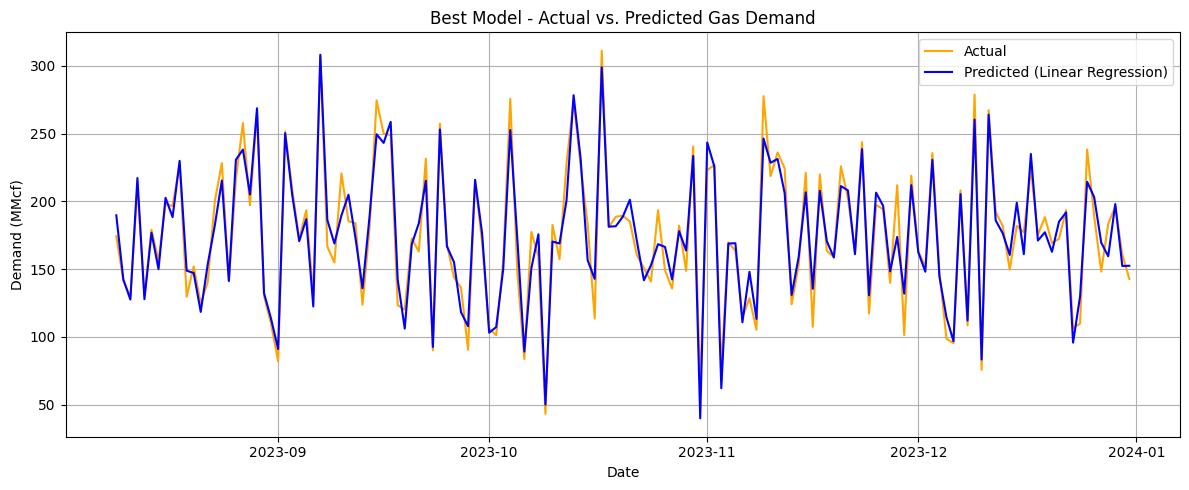

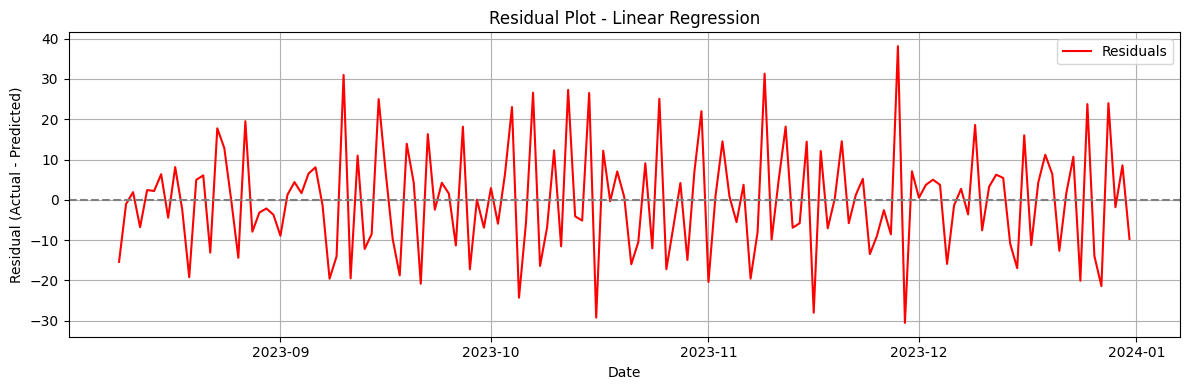

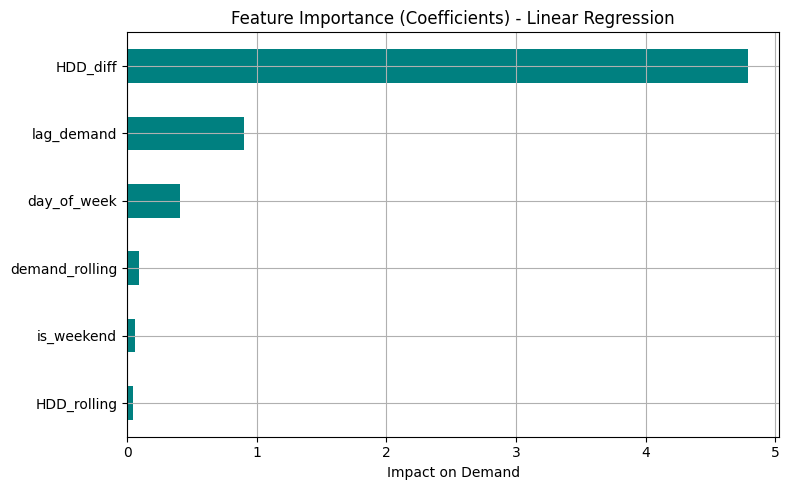

📉 Lasso Feature Coefficients:
HDD_rolling       0.000000
is_weekend        0.000000
demand_rolling    0.093934
day_of_week       0.287642
lag_demand        0.900290
HDD_diff          4.829154
dtype: float64


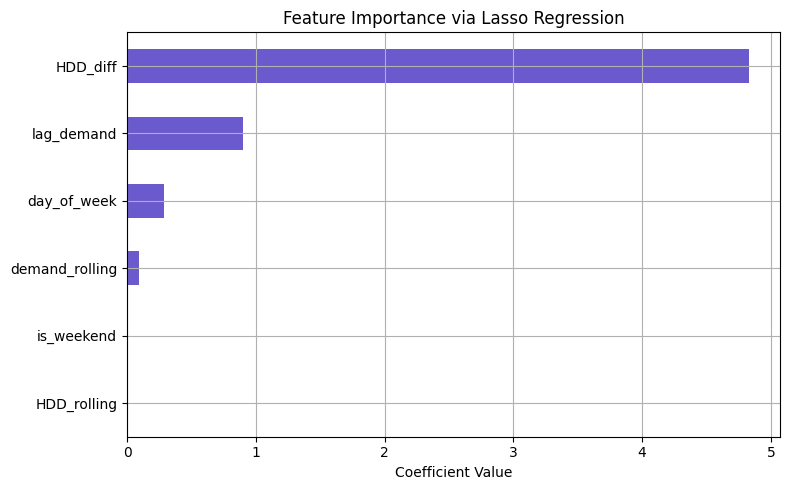

In [4]:
# 📦 Install dependencies (if needed)
!pip install scikit-learn xgboost --quiet

# 📥 Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from model import get_models, train_and_evaluate
from google.colab import drive
drive.mount('/content/drive')

# 📊 Load dataset
df = pd.read_csv("/content/drive/MyDrive/Weather Data Projects/modeling_dataset.csv", parse_dates=["date"])

# 🧠 Feature and target selection
features = ["HDD_rolling", "lag_demand", "day_of_week", "HDD_diff", "is_weekend", "demand_rolling"]
target = "demand"

# 🔁 Train all models and evaluate
models = get_models()
results = []

for model, name in models:
    print(f"Training {name}...")
    result = train_and_evaluate(model, name, df, features, target)
    results.append(result)

# 💾 Save metrics
metrics_df = pd.DataFrame([{
    "Model": r["model_name"],
    "R2 Score": r["r2_score"],
    "MAE": r["mae"]
} for r in results])

os.makedirs("outputs", exist_ok=True)
metrics_df.to_csv("/content/drive/MyDrive/Weather Data Projects/outputs/metrics.csv", index=False)

print("\n📊 Model Performance Summary:")
print(metrics_df)

# 📈 Plot best model predictions
best = max(results, key=lambda r: r["r2_score"])
# Define the Best Model as the actual model object
best_model = best["model"]

plt.figure(figsize=(12, 5))
plt.plot(df["date"].iloc[-len(best["y_test"]):], best["y_test"], label="Actual", color="orange")
plt.plot(df["date"].iloc[-len(best["y_test"]):], best["y_pred"], label=f"Predicted ({best['model_name']})", color="blue")
plt.title("Best Model - Actual vs. Predicted Gas Demand")
plt.xlabel("Date")
plt.ylabel("Demand (MMcf)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual Analysis
# 📉 Plot residuals (actual - predicted)
residuals = best["y_test"] - best["y_pred"]

plt.figure(figsize=(12, 4))
plt.plot(df["date"].iloc[-len(residuals):], residuals, color="red", label="Residuals")
plt.axhline(0, linestyle="--", color="gray")
plt.title(f"Residual Plot - {best['model_name']}")
plt.xlabel("Date")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 📊 Feature Importance (if supported)
try:
    # Linear models
    if hasattr(best_model, "coef_"):
        coefs = pd.Series(best_model.coef_, index=features).sort_values()
        plt.figure(figsize=(8, 5))
        coefs.plot(kind="barh", color="teal")
        plt.title(f"Feature Importance (Coefficients) - {best['model_name']}")
        plt.xlabel("Impact on Demand")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Tree-based models
    elif hasattr(best_model, "feature_importances_"):
        importances = pd.Series(best_model.feature_importances_, index=features).sort_values()
        plt.figure(figsize=(8, 5))
        importances.plot(kind="barh", color="forestgreen")
        plt.title(f"Feature Importance - {best['model_name']}")
        plt.xlabel("Importance")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"⚠️ Feature importance not available: {e}")


# Using Lasso to understand which features can be dropped
from sklearn.linear_model import LassoCV

# 🧠 Recreate features and target
X = df[features]
y = df[target]

# 🔍 Train Lasso with cross-validation
lasso = LassoCV(cv=5, random_state=42).fit(X, y)

# 📊 Display coefficients
lasso_coefs = pd.Series(lasso.coef_, index=features).sort_values()

print("📉 Lasso Feature Coefficients:")
print(lasso_coefs)

# 📈 Plot the Lasso coefficients
plt.figure(figsize=(8, 5))
lasso_coefs.plot(kind="barh", color="slateblue")
plt.title("Feature Importance via Lasso Regression")
plt.xlabel("Coefficient Value")
plt.grid(True)
plt.tight_layout()
plt.show()


